In [3]:
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import scipy.stats as st
import seaborn as sns

from dask import delayed, compute
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

In [4]:
cluster = LocalCluster(n_workers=16)
client = Client(cluster)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34167 instead
  warnings.warn(


In [28]:
# use_id = "00dc2d48"
use_id = "1b312256"
block_size = 40

In [29]:
df = pd.read_csv(f"{use_id}-sentences.csv", index_col=0)
df["our_cond"] = df.COND + " " + df.label

In [30]:
assert len(df) > block_size
num_blocks = int(np.ceil(len(df) / block_size))

In [31]:
df.groupby(["COND", "label"]).size()

COND  label
O+P+  high     20
      low      20
O+P-  high     20
      low      20
O-P+  high     20
      low      20
O-P-  high     20
      low      20
dtype: int64

In [58]:
# we want to maximize differences in these variables between conditions
max_variables = ["surprisal", "ortho_n_dens_s", "phono_n_dens_s"]
# we want to minimize differences in these variables between conditions
min_variables = ["word_length", "n_phon", "n_syll", "sum_bigram", "sum_biphone",
                 "lgsubtlwf", "concrete_m", "aff_val_m", "aff_arou_m",
                 "sentence_length", "entropy"]

# each of these unions of blocks should respect statistical tests within-union
candidate_blocks = [[0], [1], [2], [3], [0, 1], [2, 3], [0, 1, 2, 3]]
# each of these pairs of block unions should respect cross-modality tests
candidate_block_pairs = [([0], [2]), ([0, 1], [2, 3])]

def get_sample():
    cv = StratifiedKFold(num_blocks, shuffle=True).split(df, df.our_cond)
    s_sentences = pd.concat([df.iloc[idxs].drop(columns=["block"]) for _, idxs in cv],
                            keys=range(num_blocks), names=["block"])

    s_melted = s_sentences.reset_index().melt(
        id_vars=["block", "our_cond", "target_word", "label", "COND", "sentence"],
        value_vars=["surprisal", "entropy", "word_length", "ortho_n_dens_s",
                    "ortho_n_freq_s_m", "ortho_upoint", "old20_m",
                    "sum_bigram", "n_phon", "n_syll", "phono_n_dens_s",
                    "phono_n_freq_s_m", "phono_upoint", "pld20_m",
                    "sum_biphone", "lgsubtlwf", "concrete_m",
                    "aff_val_m", "aff_arou_m", "sentence_length"])

    return s_sentences, s_melted

# def get_stats(melted_df):
#     # compute stats for accumulated concatenated data
#     ret = []
#     for block_idx in range(num_blocks):
#         acc_df = melted_df.loc[melted_df.block <= block_idx]
#         ret.append(acc_df.groupby("variable").apply(lambda x: pd.Series(st.f_oneway(*[x.loc[x.our_cond == cond, "value"] for cond in x.our_cond.unique()]), index=["F", "p"]), include_groups=False))
#     return pd.concat(ret, keys=range(num_blocks), names=["block"]).reorder_levels(["variable", "block"])

def get_stats(melted_df):
    return melted_df.groupby("variable").apply(lambda var_df: 
        pd.Series(st.f_oneway(*[grp["value"] for _, grp in var_df.groupby(["our_cond", "block"])]),
                  index=["F", "p"]), include_groups=False)

def objective(sentence_df, melted_df, alpha=0.01, verbose=False):
    """
    Returns:
        - objective value
        - sentinel in case of failure -- can be used as a backtrace to track statistics about
          which kinds of tests yield failure more often
    """
    assert sentence_df.index.names[0] == "block"

    # First ensure that the relevant condition t-tests pass
    # we expect differences in the relevant target variables between these conds
    target_positive_tests = [("ortho_n_dens_s", "COND", "O+P+", "O-P+"),
                             ("ortho_n_dens_s", "COND", "O+P-", "O-P-"),
                             ("ortho_n_dens_s", "COND", "O-P-", "O+P+"),
                             ("phono_n_dens_s", "COND", "O+P+", "O+P-"),
                             ("phono_n_dens_s", "COND", "O-P+", "O-P-"),
                             ("phono_n_dens_s", "COND", "O-P-", "O+P+"),
                             ("surprisal", "label", "high", "low")]
    # we expect no significant differences in these variables between these conds within-block
    target_null_tests = [("ortho_n_dens_s", "COND", "O+P+", "O+P-"),
                         ("ortho_n_dens_s", "COND", "O-P+", "O-P-"),
                         ("phono_n_dens_s", "COND", "O+P-", "O-P-"),
                         ("phono_n_dens_s", "COND", "O+P+", "O-P+"),]
    # we expect no significant differences in these variables within these cond levels between-block
    target_null_between_tests = [("ortho_n_dens_s", "COND", ("O+P+", "O+P-")),
                                 ("ortho_n_dens_s", "COND", ("O-P+", "O-P-")),
                                 ("phono_n_dens_s", "COND", ("O+P-", "O-P-")),
                                 ("phono_n_dens_s", "COND", ("O+P+", "O-P+"))]
    
    for block_union in candidate_blocks:
        study_df = sentence_df.loc[block_union]
        for test_spec in target_positive_tests:
            var, grouping_variable, group1, group2 = test_spec
            study_df_ = study_df.set_index(grouping_variable)
            ttest_t, ttest_p = st.ttest_ind(study_df_.loc[group1, var], study_df_.loc[group2, var])
            if ttest_p > alpha:
                if verbose:
                    print(f"Block union {block_union} failed t-test for {var} between {group1} and {group2}")
                return -np.inf, ("positive_t", test_spec)

        for test_spec in target_null_tests:
            var, grouping_variable, group1, group2 = test_spec
            study_df_ = study_df.set_index(grouping_variable)
            ttest_t, ttest_p = st.ttest_ind(study_df_.loc[group1, var], study_df_.loc[group2, var])
            if ttest_p < alpha:
                if verbose:
                    print(f"Block union {block_union} failed t-test for {var} between {group1} and {group2}")
                return -np.inf, ("null_t", test_spec)
            
    for union1, union2 in candidate_block_pairs:
        study_df1 = sentence_df.loc[union1]
        study_df2 = sentence_df.loc[union2]
        for test_spec in target_null_between_tests:
            var, grouping_variable, groups = test_spec
            study_df1_ = study_df1.set_index(grouping_variable)
            study_df2_ = study_df2.set_index(grouping_variable)
            ftest_F, ftest_p = st.f_oneway(*([study_df1_.loc[group, var] for group in groups] +
                                             [study_df2_.loc[group, var] for group in groups]))
            if ftest_p < alpha:
                if verbose:
                    print(f"Block union {union1} vs {union2} failed F-test for {var} between {groups}")
                return -np.inf, ("between_f", test_spec)

    # F-test
    results = get_stats(melted_df)

    max_p = results.loc[max_variables, "p"].max()
    min_p = results.loc[min_variables, "p"].min()

    if max_p > alpha:
        return -np.inf, ("max_p", results.loc[max_variables, "p"].idxmax())

    # it's easy to maximize the max variables -- let's focus on the min variables
    # return max_diff - min_diff
    
    return min_p, None

In [59]:
@delayed
def sample_and_evaluate():
    s_sentences, s_melted = get_sample()
    obj, sentinel = objective(s_sentences, s_melted)
    return obj, sentinel, (s_sentences, s_melted)

In [60]:
# Create a list of delayed evaluation tasks
tasks = [sample_and_evaluate() for i in range(1000)]

# Compute all tasks in parallel
with ProgressBar():
    results = compute(*tasks, scheduler="processes")

# Extract the best sample and objective value
failure_causes = Counter()
best_objective = float("-inf")
best_sample = None

for i, (obj, sentinel, sample) in enumerate(results):
    failure_causes[sentinel] += 1
    if obj > best_objective:
        print(i, obj)
        best_objective = obj
        best_sample = sample

[                                        ] | 0% Completed | 125.54 ms

/home/jgauthier/u/transformers/lib/python3.10/site-packages/dask/base.py:1487: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[########################################] | 100% Completed | 9.20 ss


In [61]:
failure_causes

Counter({('positive_t', ('phono_n_dens_s', 'COND', 'O-P+', 'O-P-')): 699,
         ('positive_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O+P-')): 276,
         ('null_t', ('phono_n_dens_s', 'COND', 'O+P-', 'O-P-')): 11,
         ('null_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O+P-')): 8,
         ('positive_t', ('phono_n_dens_s', 'COND', 'O-P-', 'O+P+')): 5,
         ('null_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O-P+')): 1})

In [62]:
s_sentences, s_melted = best_sample
s_stats = get_stats(s_melted).sort_values("p")

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
assert s_sentences.index.get_level_values(-1).value_counts().max() == 1

In [ ]:
s_sentences.groupby(["block", "our_cond"]).size()

block  our_cond 
0      O+P+ high    5
       O+P+ low     5
       O+P- high    5
       O+P- low     5
       O-P+ high    5
       O-P+ low     5
       O-P- high    5
       O-P- low     5
1      O+P+ high    5
       O+P+ low     5
       O+P- high    5
       O+P- low     5
       O-P+ high    5
       O-P+ low     5
       O-P- high    5
       O-P- low     5
2      O+P+ high    5
       O+P+ low     5
       O+P- high    5
       O+P- low     5
       O-P+ high    5
       O-P+ low     5
       O-P- high    5
       O-P- low     5
3      O+P+ high    5
       O+P+ low     5
       O+P- high    5
       O+P- low     5
       O-P+ high    5
       O-P+ low     5
       O-P- high    5
       O-P- low     5
dtype: int64

In [ ]:
s_sentences.to_csv(f"{use_id}-blocked.csv")

In [ ]:
b0 = s_sentences.loc[0]
st.ttest_ind(b0[b0.COND == "O+P-"].ortho_n_dens_s, b0[b0.COND == "O+P+"].ortho_n_dens_s)

TtestResult(statistic=-0.2784097012003855, pvalue=0.7838709286832881, df=18.0)

In [ ]:
s_stats.loc[max_variables].p.max()

0.0018948293069251496

In [ ]:
s_stats.to_csv(f"{use_id}-blocked-stats.csv")

In [ ]:
order = sorted(s_melted.label.unique())
hue_order = sorted(s_melted.COND.unique())

Text(0.5, 0.98, 'Target manipulations')

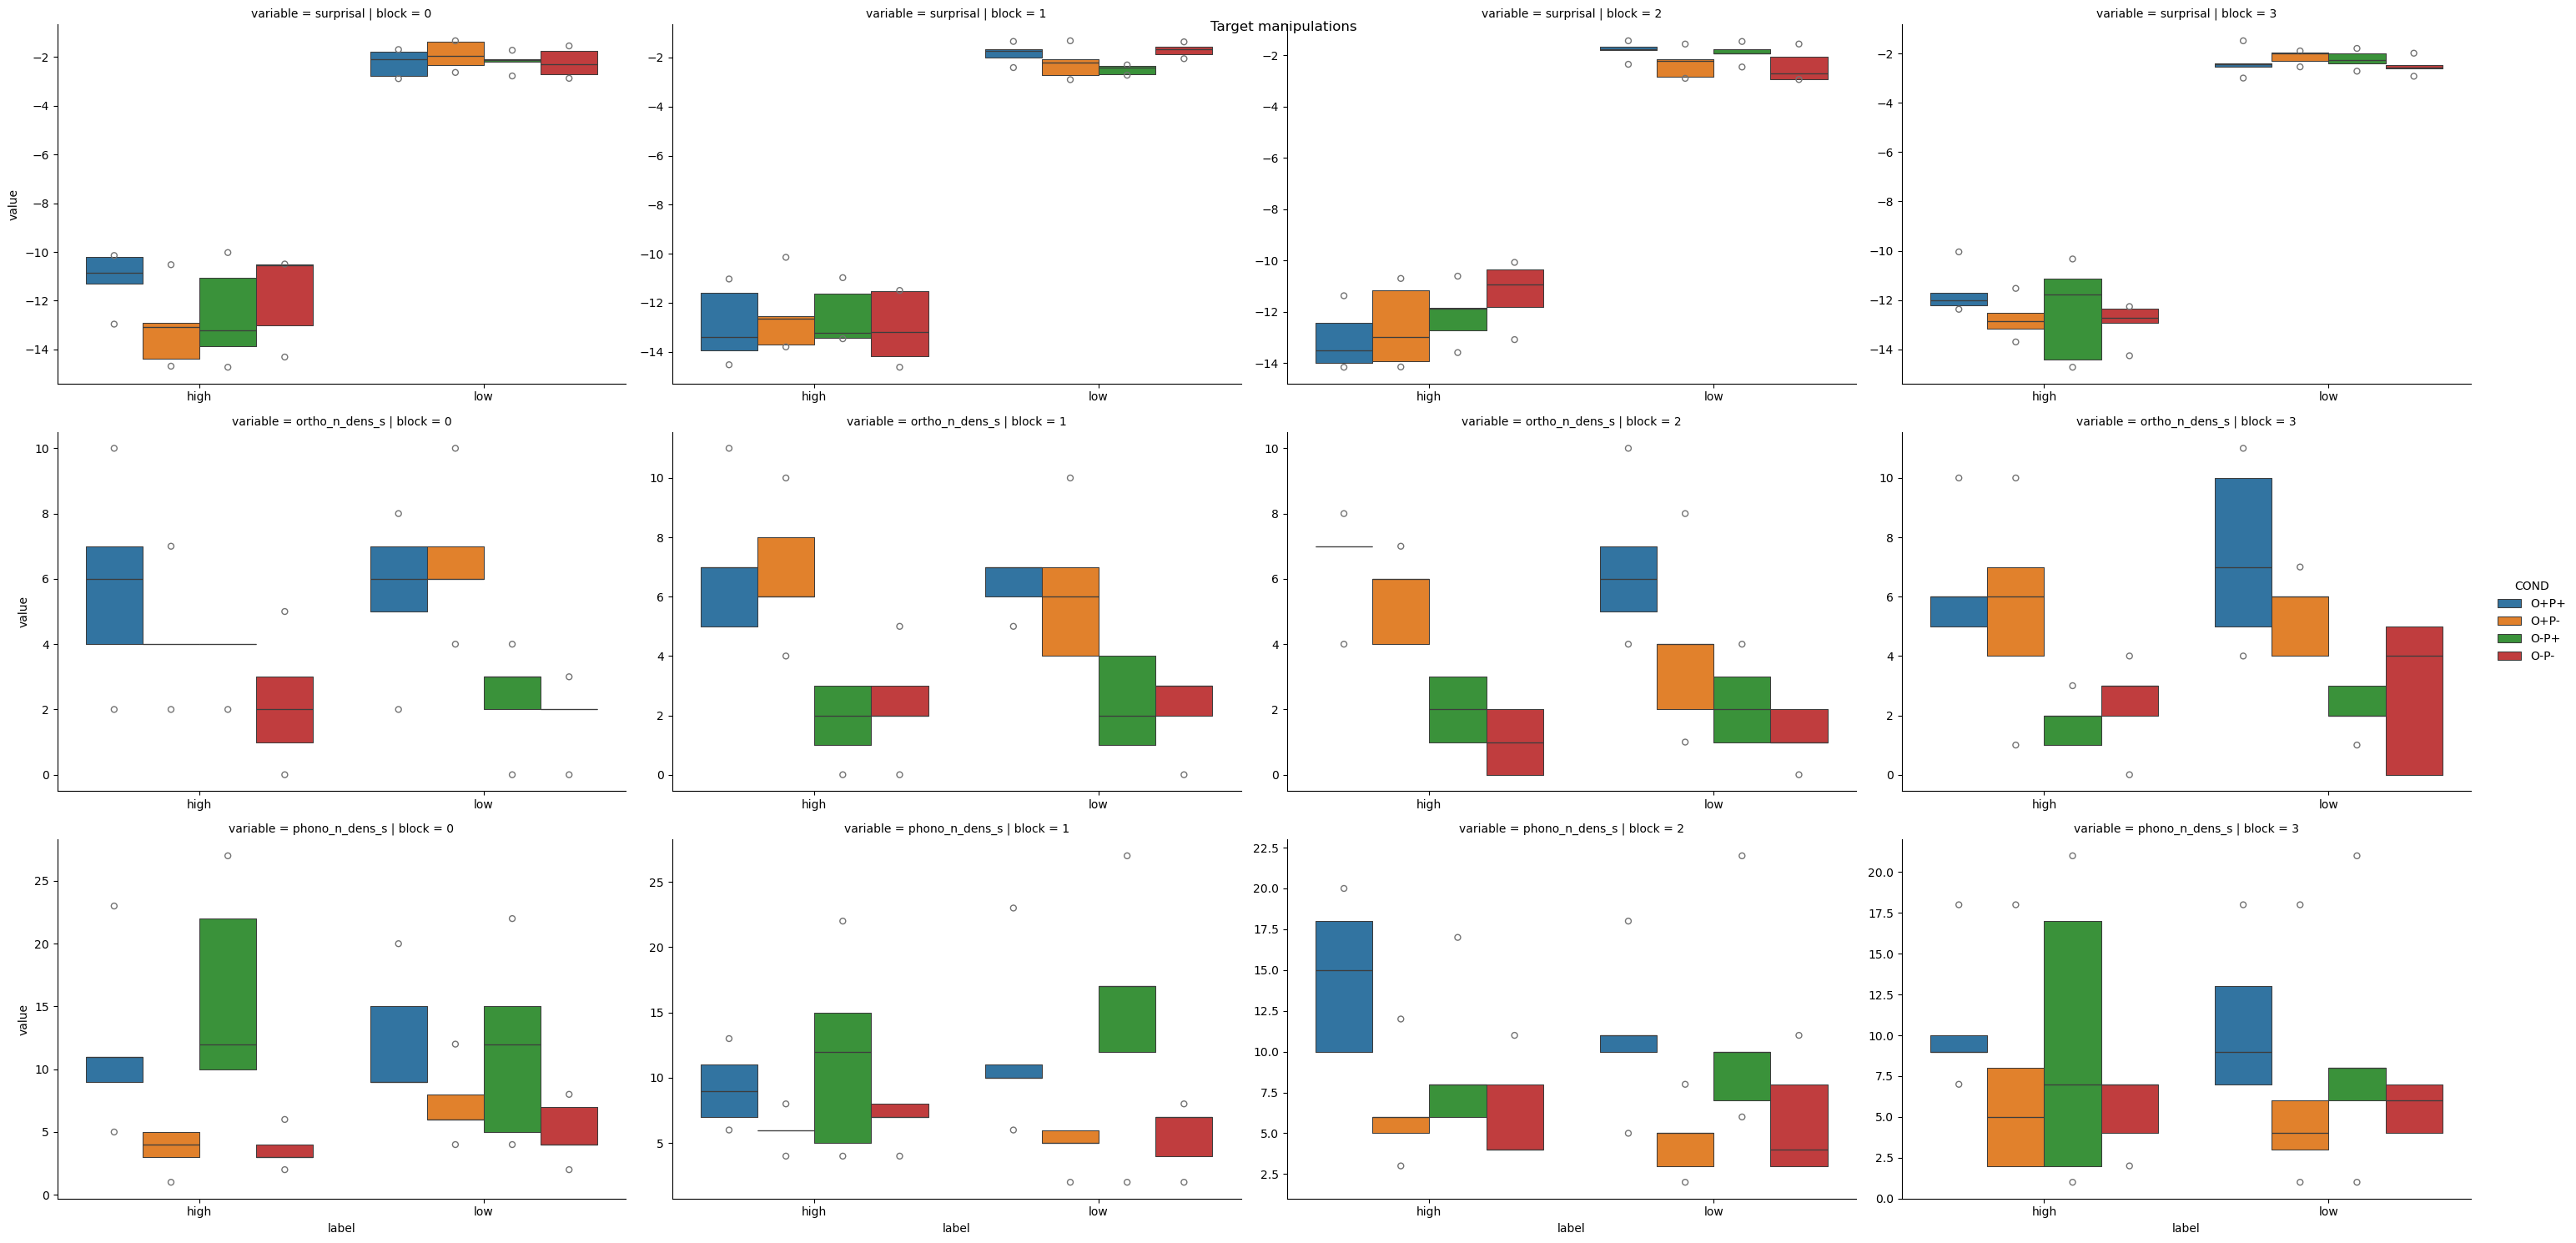

In [ ]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(max_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                order=order, hue_order=hue_order,
                kind="boxen", aspect=1.5, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

Text(0.5, 0.98, 'Aim to match between conditions')

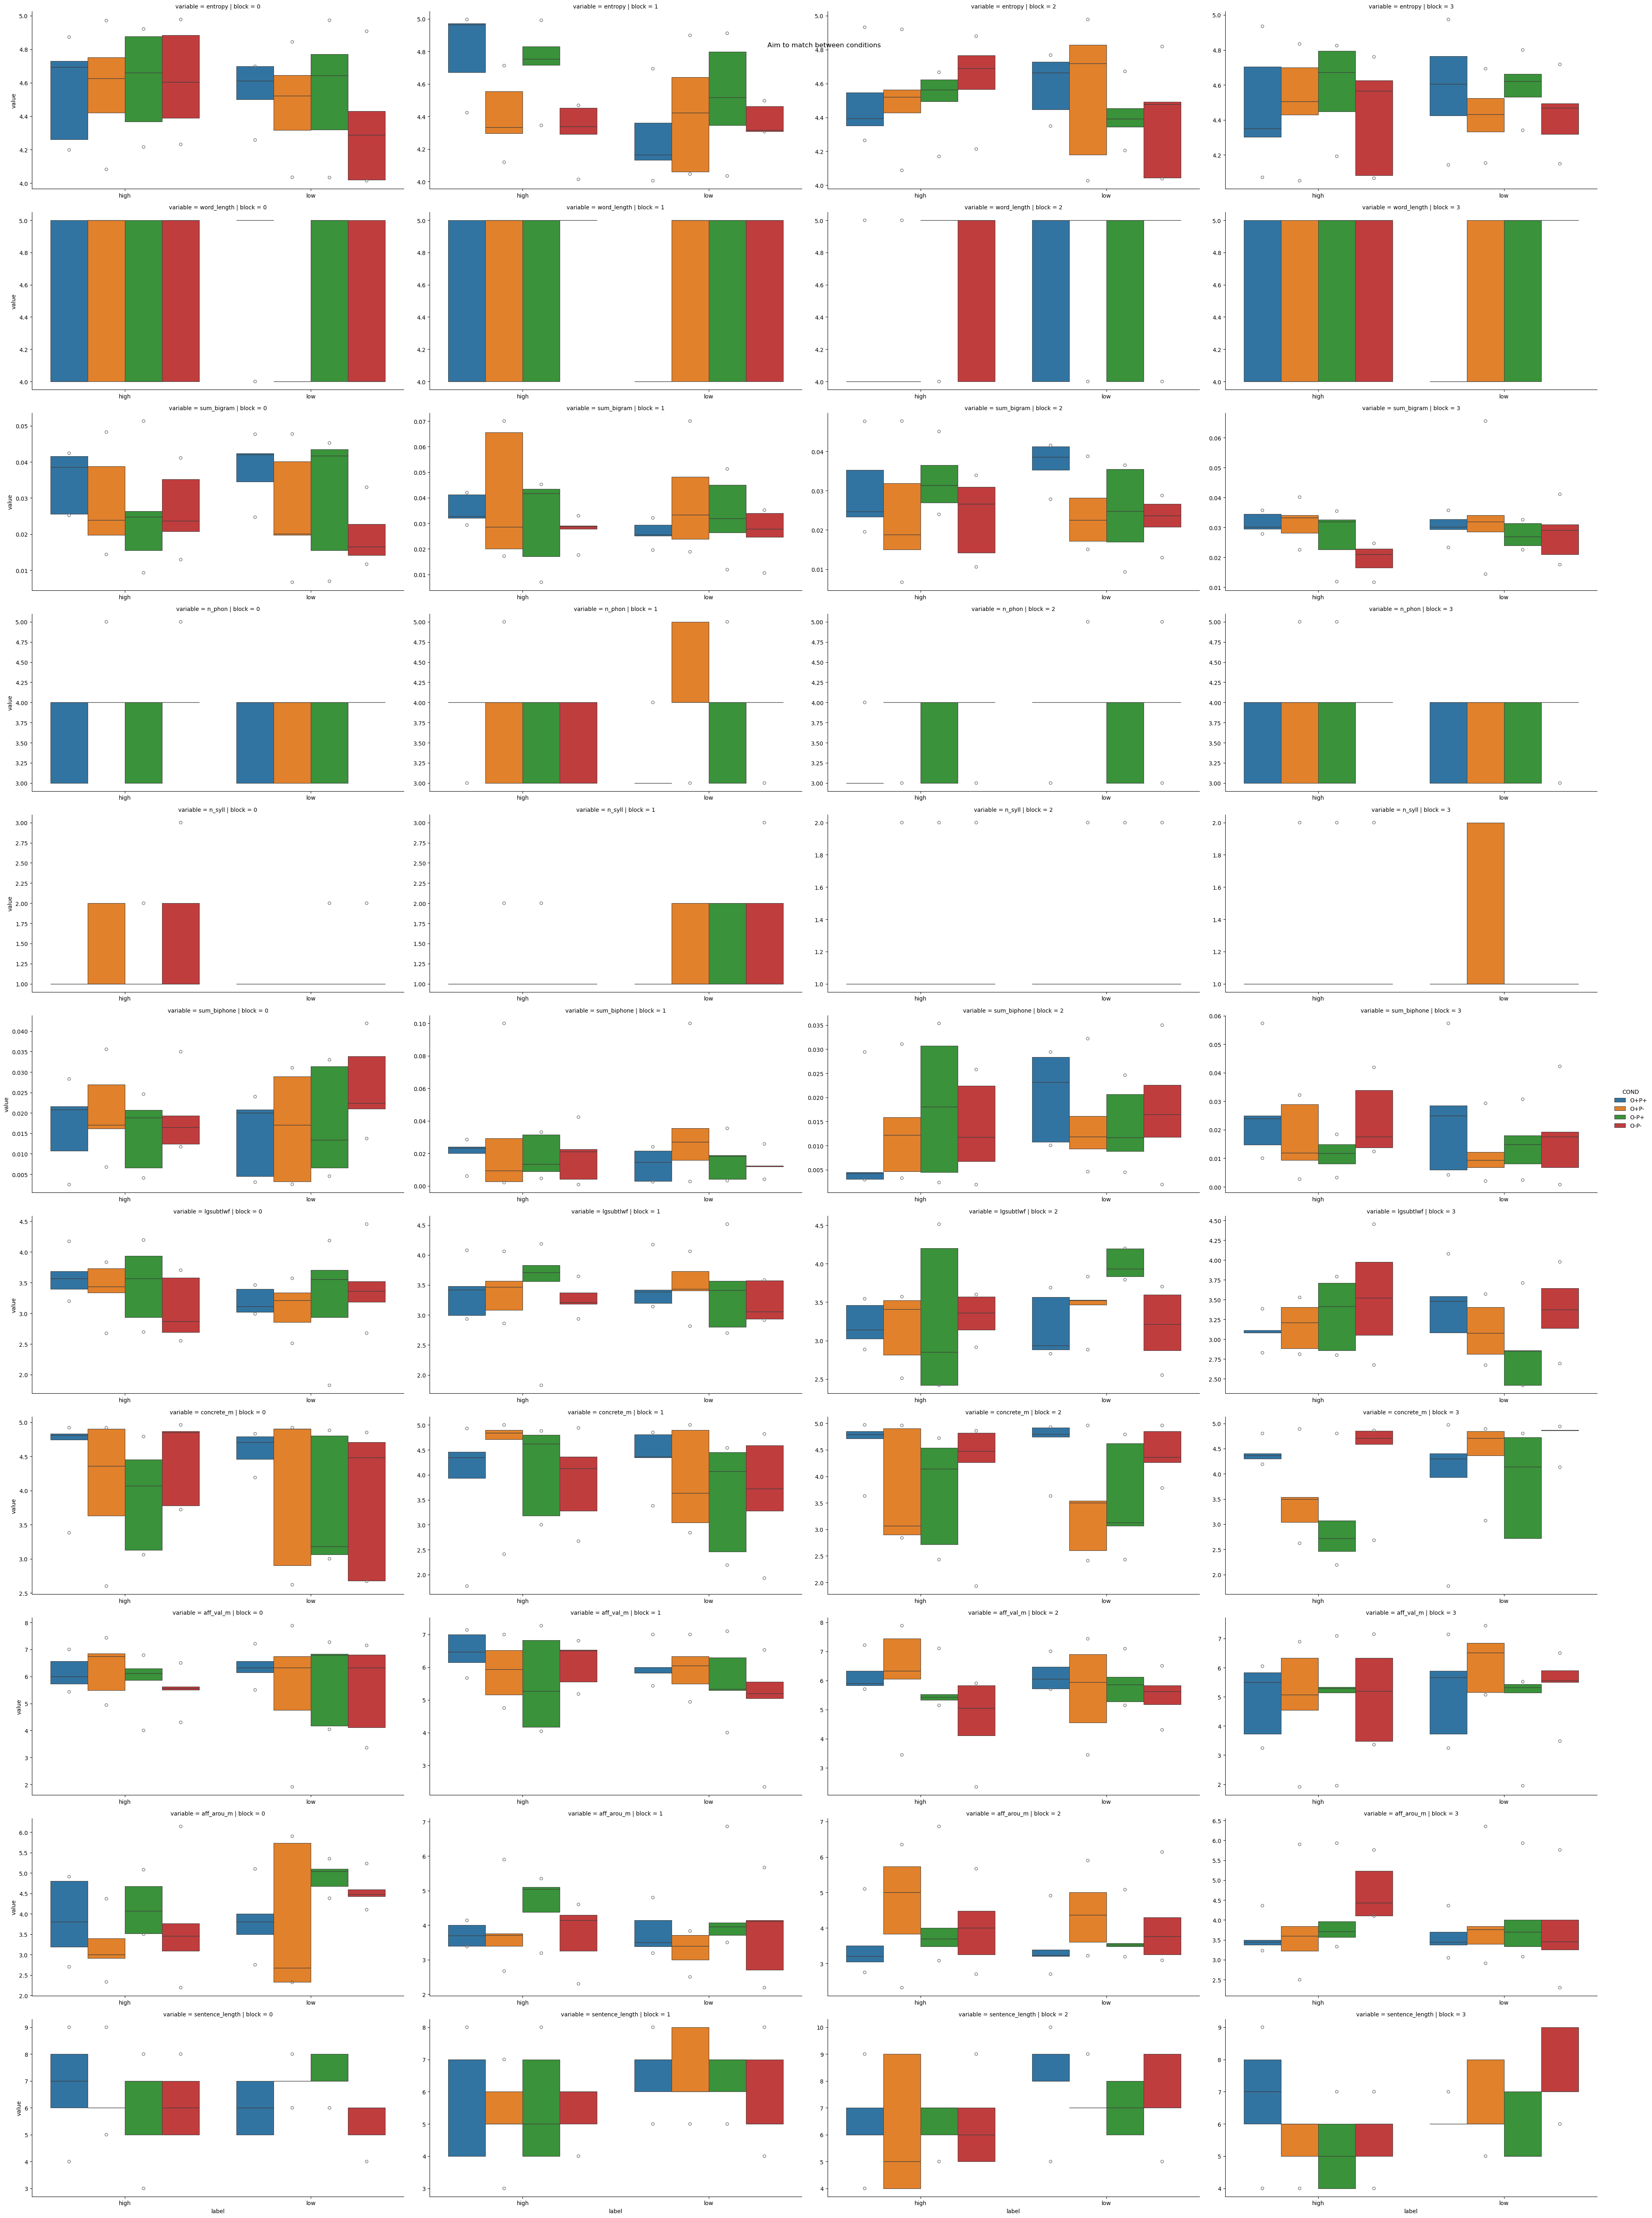

In [ ]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(min_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                order=order, hue_order=hue_order,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

Text(0.5, 0.98, 'Other stuff')

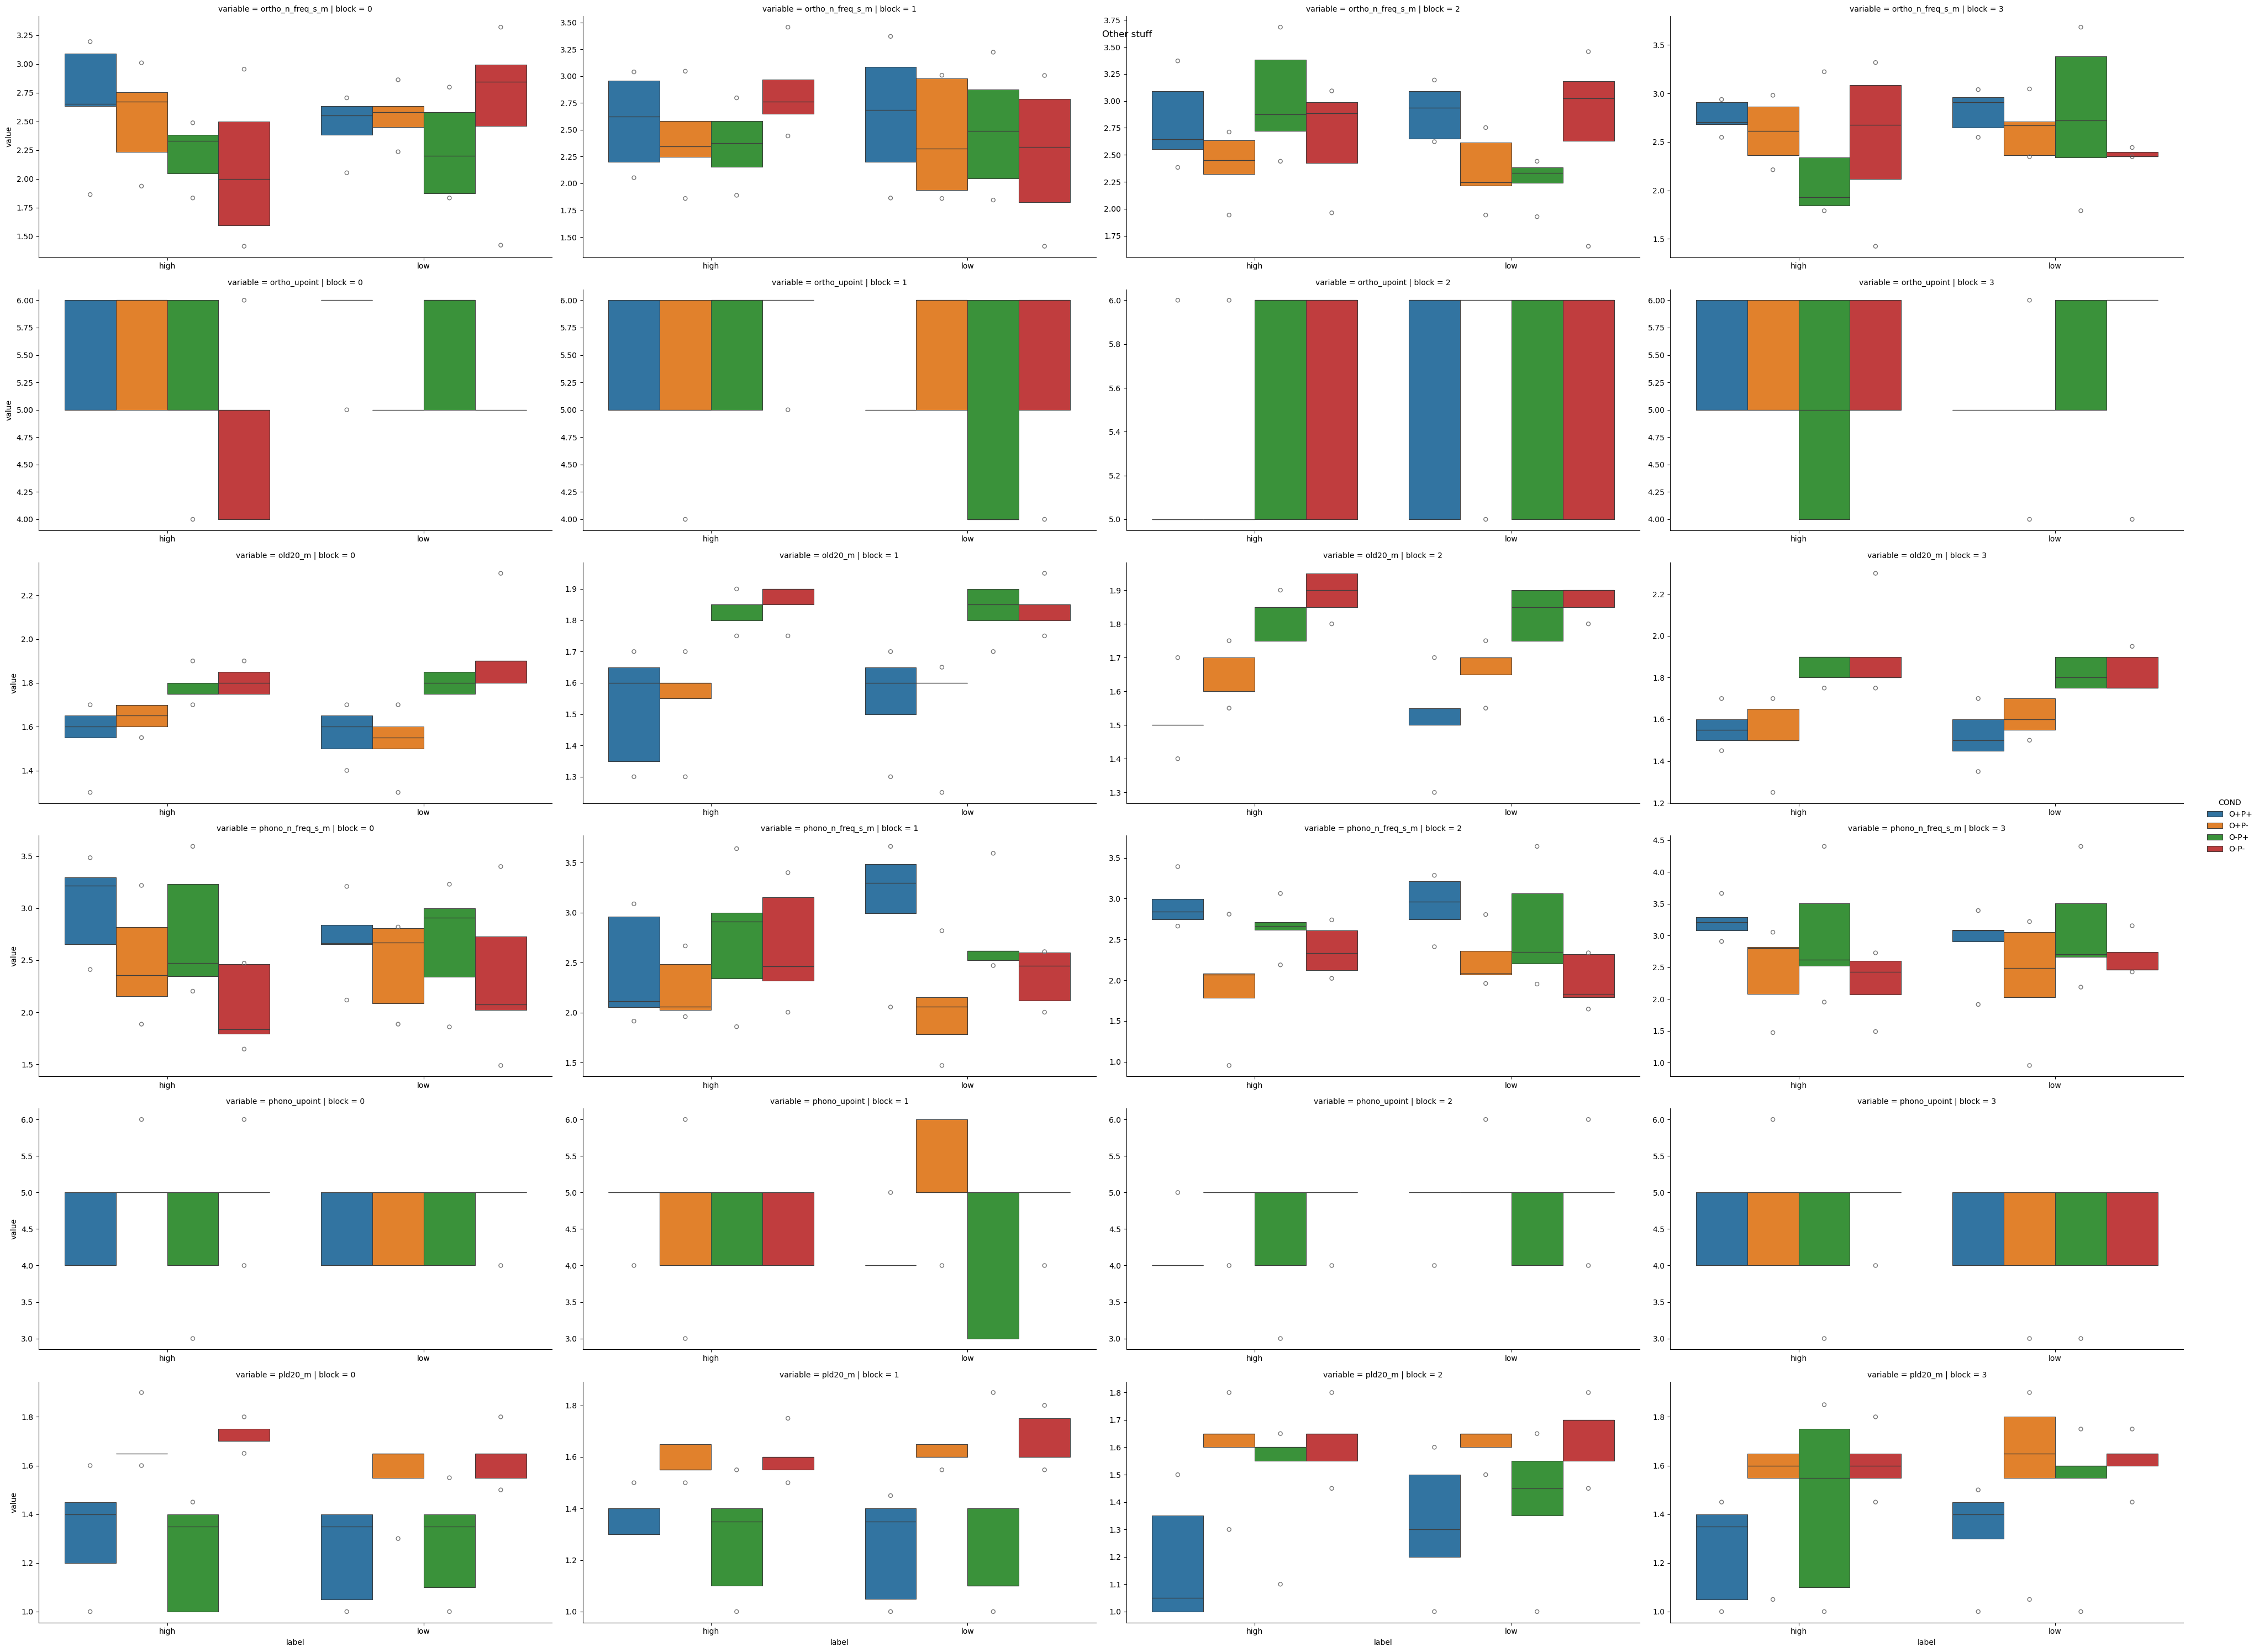

In [ ]:
g = sns.catplot(data=s_melted[~s_melted.variable.isin(min_variables + max_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                order=order, hue_order=hue_order,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")